(quick_echopype_exercise)=
# Echopype: a quick exercise

In this exercise we will do 4 things:
- convert a `.raw` file collected by an EK80 echosounder
- compute volume backscattering strength (Sv) from the parsed raw data
- regrid the Sv data to mean volume backscattering strength (MVBS)
- visualize using interactive plot

For more detials, see the [Getting started with Echopype notebook](https://echopype-examples.readthedocs.io/en/latest/getting_started.html) in the ["echopype-examples" repository](https://github.com/OSOceanAcoustics/echopype-examples).

In [1]:
import echopype as ep  # we recommend using "ep"
import xarray as xr
import hvplot.xarray  # for interactive plots

import matplotlib.pyplot as plt

### Convert a `.raw` file

Echopype supports accessing data directly from multiple sources, such as a local filesystem (e.g., hard disk), a cloud object store (e.g., AWS S3), an http server, etc.

In [2]:
# Convert from an S3 bucket
raw_path = "s3://noaa-wcsd-pds/data/raw/Bell_M._Shimada/SH2306/EK80/Hake-D20230811-T165727.raw"
ed = ep.open_raw(
    raw_path,
    sonar_model="EK80",
    storage_options={"anon": True},  # open bucket, otherwise need credential
)

### Check what's in the raw file

In [3]:
ed

<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data, including split-beam angle data when they exist.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

### Save the `EchoData` object

In [4]:
# Save to zarr
ed.to_zarr("./resources", overwrite="w")  # save with the same filename, different extension

In [5]:
# Save to netCDF
ed.to_netcdf("./resources/Hake-D20230811-T165727.nc", overwrite="w")  # fully specify the filename also works

### Im-memory vs lazy-loaded data

In [6]:
# Lazy-load EchoData using xarray kwargs (keyword arguments)
ed_lazy = ep.open_converted("./resources/Hake-D20230811-T165727.zarr", chunks={})

In [7]:
# In-memory
ed["Sonar/Beam_group1"]["backscatter_r"]

<xarray.DataArray 'backscatter_r' (channel: 5, ping_time: 213,
                                   range_sample: 36198)> Size: 154MB
array([[[  10.383183  ,   13.875601  ,   16.015736  , ...,
                   nan,           nan,           nan],
        [  10.430219  ,   13.910878  ,   16.051014  , ...,
                   nan,           nan,           nan],
        [  10.383183  ,   13.875601  ,   16.015736  , ...,
                   nan,           nan,           nan],
        ...,
        [  10.465496  ,   13.969673  ,   16.121567  , ...,
                   nan,           nan,           nan],
        [  10.465496  ,   13.969673  ,   16.121567  , ...,
                   nan,           nan,           nan],
        [  10.430219  ,   13.899119  ,   16.051014  , ...,
                   nan,           nan,           nan]],

       [[ -11.782502  ,   -5.7031074 ,   -0.50563633, ...,
         -125.868164  , -126.09158   , -126.29149   ],
        [ -11.711948  ,   -5.6443124 ,   -0.47035936, ...,
         -133.06467   , -130.23074   , -127.82016   ],
        [ -11.770743  ,   -5.6795893 ,   -0.49387732, ...,
         -133.14697   , -132.48848   , -131.8182    ],
...
        [   3.5394542 ,   10.41846   ,   15.780557  , ...,
                   nan,           nan,           nan],
        [   3.4689002 ,   10.383183  ,   15.757039  , ...,
                   nan,           nan,           nan],
        [   3.4924183 ,   10.383183  ,   15.757039  , ...,
                   nan,           nan,           nan]],

       [[   6.067636  ,    8.866274  ,   10.747711  , ...,
                   nan,           nan,           nan],
        [   6.079395  ,    8.842756  ,   10.747711  , ...,
                   nan,           nan,           nan],
        [   6.2087436 ,    9.019141  ,   10.912337  , ...,
                   nan,           nan,           nan],
        ...,
        [   6.3028154 ,    9.077936  ,   10.959373  , ...,
                   nan,           nan,           nan],
        [   6.2087436 ,    9.0309    ,   10.935855  , ...,
                   nan,           nan,           nan],
        [   6.3028154 ,    9.077936  ,   10.971132  , ...,
                   nan,           nan,           nan]]], dtype=float32)
Coordinates:
  * channel       (channel) <U25 500B 'WBT 400140-15 ES120-7C_ES' ... 'WBT 40...
  * ping_time     (ping_time) datetime64[ns] 2kB 2023-08-11T16:57:27.277163 ....
  * range_sample  (range_sample) int64 290kB 0 1 2 3 ... 36194 36195 36196 36197
Attributes:
    long_name:  Raw backscatter measurements (real part)
    units:      dB

In [8]:
# Lazy-loaded
ed_lazy["Sonar/Beam_group1"]["backscatter_r"]

<xarray.DataArray 'backscatter_r' (channel: 5, ping_time: 213,
                                   range_sample: 36198)> Size: 154MB
dask.array<open_dataset-backscatter_r, shape=(5, 213, 36198), dtype=float32, chunksize=(5, 213, 23474), chunktype=numpy.ndarray>
Coordinates:
  * channel       (channel) <U25 500B 'WBT 400140-15 ES120-7C_ES' ... 'WBT 40...
  * ping_time     (ping_time) datetime64[ns] 2kB 2023-08-11T16:57:27.277163 ....
  * range_sample  (range_sample) int64 290kB 0 1 2 3 ... 36194 36195 36196 36197
Attributes:
    long_name:  Raw backscatter measurements (real part)
    units:      dB

### Compute Sv

In [9]:
# Use the correct waveform_mode and encode_mode combination
ds_Sv = ep.calibrate.compute_Sv(ed, waveform_mode="CW", encode_mode="power")
ds_Sv = ep.consolidate.add_depth(ds_Sv, ed)

Check how the Sv data look like:

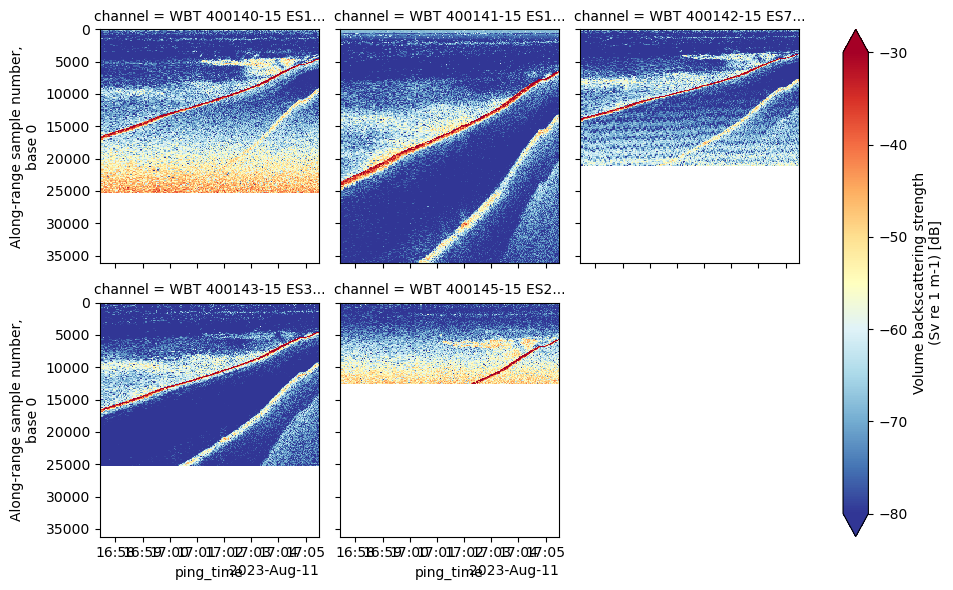

In [10]:
ds_Sv["Sv"].plot(
    x="ping_time", 
    row="channel", col_wrap=3,
    vmin=-80, vmax=-30,
    cmap="RdYlBu_r", yincrease=False
)

### Regrid to MVBS

In [11]:
# Compute MVBS
ds_MVBS = ep.commongrid.compute_MVBS(
    ds_Sv,
    range_var="depth",
    range_bin="1m",
    ping_time_bin="5s",
    range_var_max="500m",  # max range to bin
)

See how MVBS data are now all aligned with one another (hence the name `commingrid`):

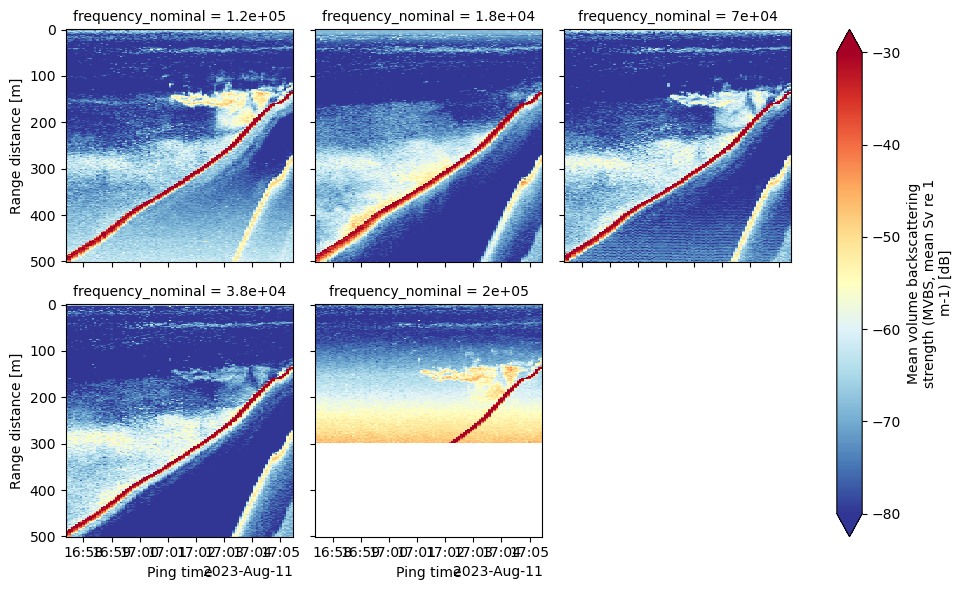

In [12]:
ds_MVBS = ds_MVBS.swap_dims({"channel": "frequency_nominal"})
ds_MVBS["Sv"].plot(
    x="ping_time",
    row="frequency_nominal", col_wrap=3,
    cmap='RdYlBu_r', yincrease=False,
    vmin=-80, vmax=-30
)

### Try interactive plotting

In [13]:
ds_MVBS["Sv"].hvplot.quadmesh(
    x="ping_time", clim=(-80, -30), figsize=(6, 6), cmap="RdYlBu_r", rasterize=True,
    groupby="frequency_nominal"
).opts(invert_yaxis=True, height=400)

:DynamicMap   [frequency_nominal]
   :Image   [ping_time,depth]   (Mean volume backscattering strength (MVBS, mean Sv re 1 m-1))

### Save the MVBS dataset for future use

In [14]:
ds_MVBS.to_zarr("./resources/Hake-D20230811-T165727_MVBS.zarr", mode="w")